# Introduction

We are going to fix a 5-year bugs in the RNA-seq pipeline, i.e. the strandness mistake. We took for granted that all the samples before and after CCLE 2019 papers are coming from the non-stranded protocols, but it is not true. We will systematically benchmark the effects.

## Outline
- [Setup](#setup)
- [Strandness](#understanding-strandness-statistics)
- [All genes impact](#all-genes-expression-benchmarking)
- [Protein coding genes impact](#protein-coding-genes-impact)

# Setup 

First, we need to setup the environment for the experiments.

In [2]:
import pandas as pd
import dalmatian as dm
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from sklearn.decomposition import PCA
tc = TaigaClient()
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')

In [3]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)
protcod_rename = {}
protcod_ensem = []
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )
        protcod_ensem.append(i.ensembl_gene_id)

downloading gene names from biomart


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [4]:
protcod_ensem[:10], len(protcod_ensem)

(['ENSG00000198888',
  'ENSG00000198763',
  'ENSG00000198804',
  'ENSG00000198712',
  'ENSG00000228253',
  'ENSG00000198899',
  'ENSG00000198938',
  'ENSG00000198840',
  'ENSG00000212907',
  'ENSG00000198886'],
 21704)

In [5]:
allgenes_rename = {}
for _, i in mybiomart.iterrows():
    if i.ensembl_gene_id not in allgenes_rename:
        if i.hgnc_symbol:
            allgenes_rename.update(
                {
                    i.ensembl_gene_id: i.hgnc_symbol
                    + " ("
                    + str(i.ensembl_gene_id)
                    + ")"
                }
            )
        else:
            allgenes_rename.update(
                {
                    i.ensembl_gene_id: i.ensembl_gene_id
                }
            )

In [6]:
len(protcod_ensem)

21704

In [7]:
model_dataset = pd.read_csv("~/23Q4_model.csv", index_col=0)

In [8]:
model_dataset.head()

PatientID CellLineName StrippedCellLineName DepmapModelType  \
ModelID                                                                   
ACH-000001  PT-gj46wT  NIH:OVCAR-3            NIHOVCAR3           HGSOC   
ACH-000002  PT-5qa3uk        HL-60                 HL60             AML   
ACH-000003  PT-puKIyc        CACO2                CACO2            COAD   
ACH-000004  PT-q4K2cp          HEL                  HEL             AML   
ACH-000005  PT-q4K2cp   HEL 92.1.7              HEL9217             AML   

                 OncotreeLineage     OncotreePrimaryDisease  \
ModelID                                                       
ACH-000001  Ovary/Fallopian Tube   Ovarian Epithelial Tumor   
ACH-000002               Myeloid     Acute Myeloid Leukemia   
ACH-000003                 Bowel  Colorectal Adenocarcinoma   
ACH-000004               Myeloid     Acute Myeloid Leukemia   
ACH-000005               Myeloid     Acute Myeloid Leukemia   

                             OncotreeSubtype OncotreeCode  \
ModelID                                                     
ACH-000001  High-Grade Serous Ovarian Cancer        HGSOC   
ACH-000002            Acute Myeloid Leukemia          AML   
ACH-000003              Colon Adenocarcinoma         COAD   
ACH-000004            Acute Myeloid Leukemia          AML   
ACH-000005            Acute Myeloid Leukemia          AML   

           LegacyMolecularSubtype  PatientMolecularSubtype  ... TissueOrigin  \
ModelID                                                     ...                
ACH-000001                    NaN                      NaN  ...          NaN   
ACH-000002                    NaN                      NaN  ...          NaN   
ACH-000003                    NaN                      NaN  ...          NaN   
ACH-000004                    NaN                      NaN  ...          NaN   
ACH-000005                    NaN                      NaN  ...          NaN   

                                              CCLEName CatalogNumber  \
ModelID                                                                
ACH-000001                             NIHOVCAR3_OVARY        HTB-71   
ACH-000002     HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       CCL-240   
ACH-000003                       CACO2_LARGE_INTESTINE        HTB-37   
ACH-000004      HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE        ACC 11   
ACH-000005  HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE       HEL9217   

           PlateCoating ModelDerivationMaterial PublicComments  \
ModelID                                                          
ACH-000001         None                     NaN            NaN   
ACH-000002         None                     NaN            NaN   
ACH-000003         None                     NaN            NaN   
ACH-000004         None                     NaN            NaN   
ACH-000005         None                     NaN            NaN   

           WTSIMasterCellID SangerModelID  COSMICID   LegacySubSubtype  
ModelID                                                                 
ACH-000001           2201.0     SIDM00105  905933.0  high_grade_serous  
ACH-000002             55.0     SIDM00829  905938.0                 M3  
ACH-000003              NaN     SIDM00891       NaN                NaN  
ACH-000004            783.0     SIDM00594  907053.0                 M6  
ACH-000005              NaN     SIDM00593       NaN                 M6  

[5 rows x 35 columns]

In [9]:
wm = dm.WorkspaceManager("broad-firecloud-ccle/DepMap_hg38_RNAseq")
terra_rnaseq_df = wm.get_samples()

dev_wm = dm.WorkspaceManager("broad-firecloud-ccle/Dev_DepMap_hg38_RNAseq")
dev_terra_rnaseq_df = dev_wm.get_samples()

inputs = terra_rnaseq_df.rna_strand_output[~terra_rnaseq_df.rna_strand_output.isnull()]
profile_ids = terra_rnaseq_df.ProfileID[~terra_rnaseq_df.rna_strand_output.isnull()]

meta = pd.read_table("~/all_meta_oncotree.tsv")

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5948/2324254461.py:10: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_table("~/all_meta_oncotree.tsv")


# Understanding strandness statistics

In [10]:
def load_rnaseqc(terra_path):
    rnaseqc_count_df = pd.read_csv(terra_path, sep=':', skiprows=3, header=None, index_col=0)
    return rnaseqc_count_df


from multiprocessing import Pool
pool = Pool(12)
strand_count_dfs = pool.map(load_rnaseqc, inputs)
pool.close()
strand_count_dfs = pd.concat(strand_count_dfs, axis=1)
strand_count_dfs = strand_count_dfs.T
strand_count_dfs.index = inputs.index
strand_count_dfs.loc[:, "Profile"] = strand_count_dfs.index.map(dict(zip(meta.MainSequencingID, meta.ProfileID)))

<Axes: xlabel='Fraction of reads explained by "1++,1--,2+-,2-+"', ylabel='Density'>

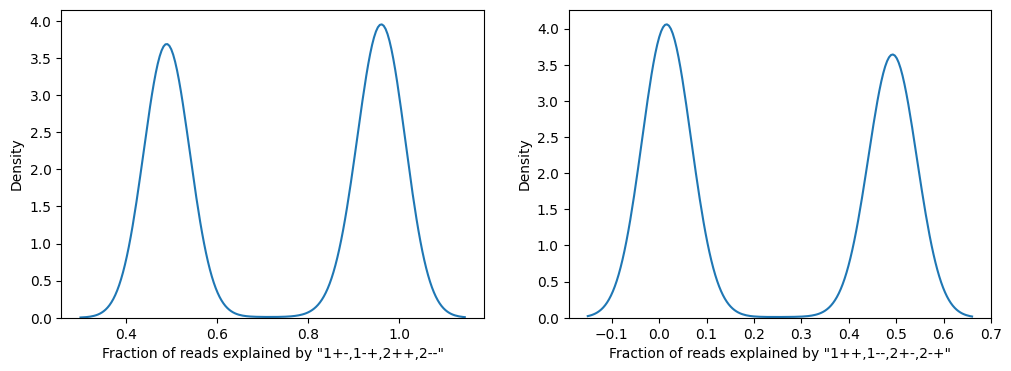

In [13]:
strand_count_dfs.loc[:, 'strandness'] = strand_count_dfs.iloc[:, 2] > 0.7
strand_count_dfs.to_csv("rna_strandness_24q2.csv")
import seaborn as sns
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.kdeplot(strand_count_dfs.iloc[:, 2], ax=ax[0])
sns.kdeplot(strand_count_dfs.iloc[:, 1], ax=ax[1])

In [11]:
# update = False
# if update:
#    new_dataset_id = tc.update_dataset(
#         dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
#         changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
#         upload_files=[
#             {
#                 "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
#                 "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
#                 "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
#                 "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
#             }
#         ],
#         upload_async=False,
#         dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
#    )
# else:
#    new_dataset_id = tc.create_dataset(
#        "rnaseq_strandness_inference",
#        dataset_description="RSeQC statistical inference of RNA-seq strandness",
#        upload_files=[
#            {
#                "path": "rna_strandness_24q2.csv",
#                "name": "rnaseq_strandness_inference", # optional, will use file name if not provided
#                "format": "TableCSV", # or "NumericMatrixCSV" or "TableCSV"
#                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
#            }
#        ],
#        folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
#    )

# new_dataset_id

Our conclusion is half of our samples are non-stranded RNA-seq, the rest are from reverse stranded RNA-seq.

## lineage distribution between non-stranded and stranded sequencing

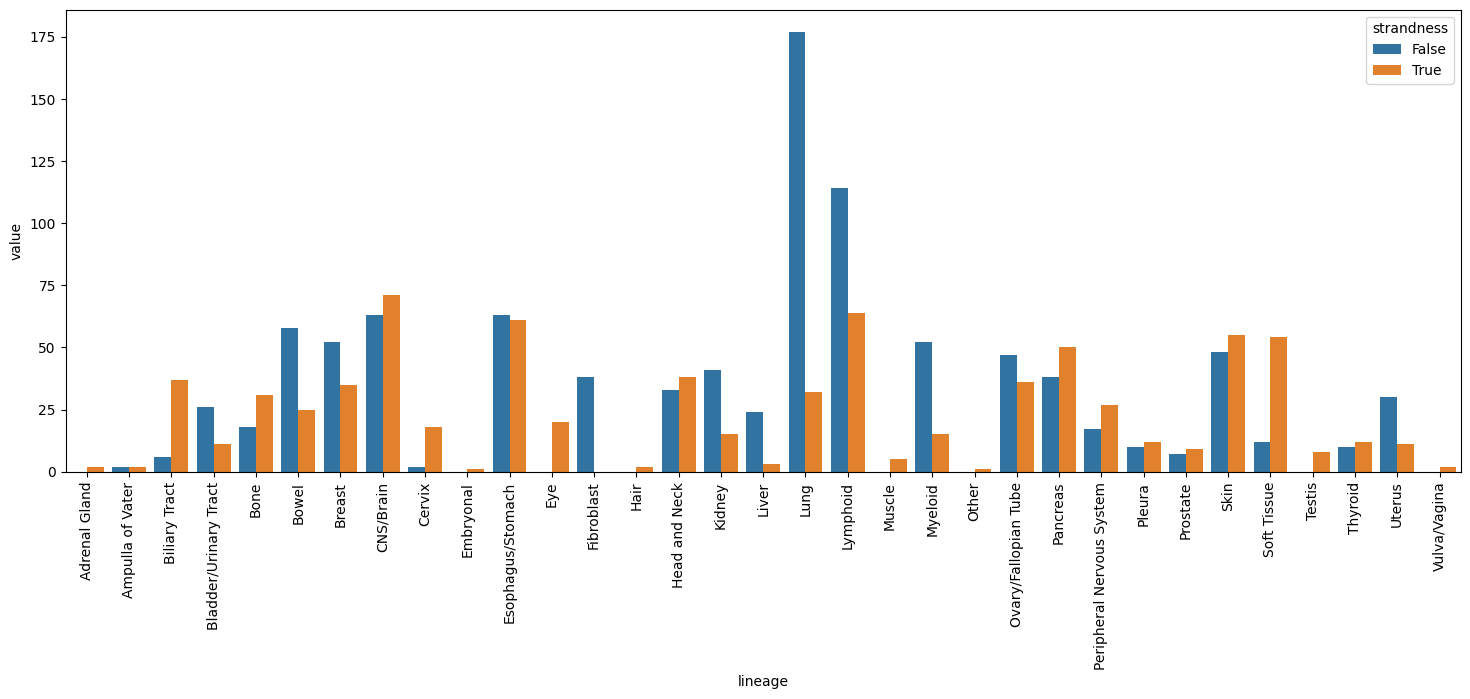

In [14]:
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')

profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]
lineage = OmicsExpressionAllGenesTPMLogp1Profile.index.map(profile_to_model_dict).map(model_dataset.OncotreeLineage.to_dict())

pca_plot_data = pd.DataFrame({"lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
stat = pd.crosstab(pca_plot_data.iloc[:, 0], pca_plot_data.iloc[:, 1])
stat.melt(ignore_index=False).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
g = sns.barplot(data=stat.melt(ignore_index=False).reset_index(), x='lineage', y='value', hue='strandness')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [31]:
stat.loc[:, 'total'] = stat.sum(axis=1)

In [32]:
stat_sub = stat.copy()

In [33]:
stat_sub = stat_sub.apply(lambda x: x[:2]/ x[-1], axis=1)

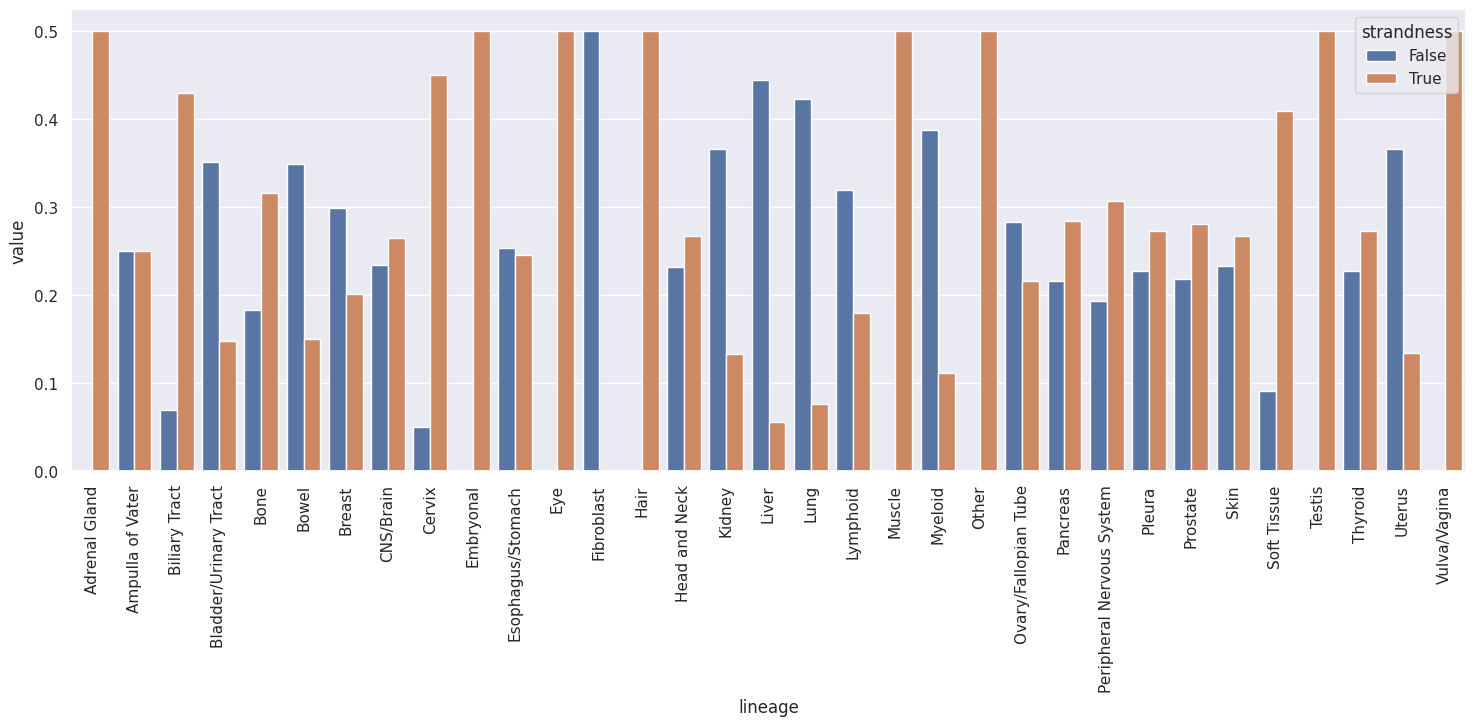

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
g = sns.barplot(data=stat_sub.melt(ignore_index=False).reset_index(), x='lineage', y='value', hue='strandness')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

# All genes expression benchmarking

## Paired non-strand and strand rsem results comparison on the same sample

In [20]:
paired_data = dev_terra_rnaseq_df.loc[~dev_terra_rnaseq_df.rsem_genes_strandness.isnull(), 'rsem_genes_strandness'].reset_index().merge(
    terra_rnaseq_df.loc[:, ['rsem_genes']].reset_index(), on='sample_id')

475
263
195
247
283
208
530
320
337
257
302
334
313
301
311
347
305
420
281
279
352
303
275
299
416
241
328
309
295
247
288
361
437
212
342
333
601
252
300
326
411
308
332
368
283
238
282
322
413
300


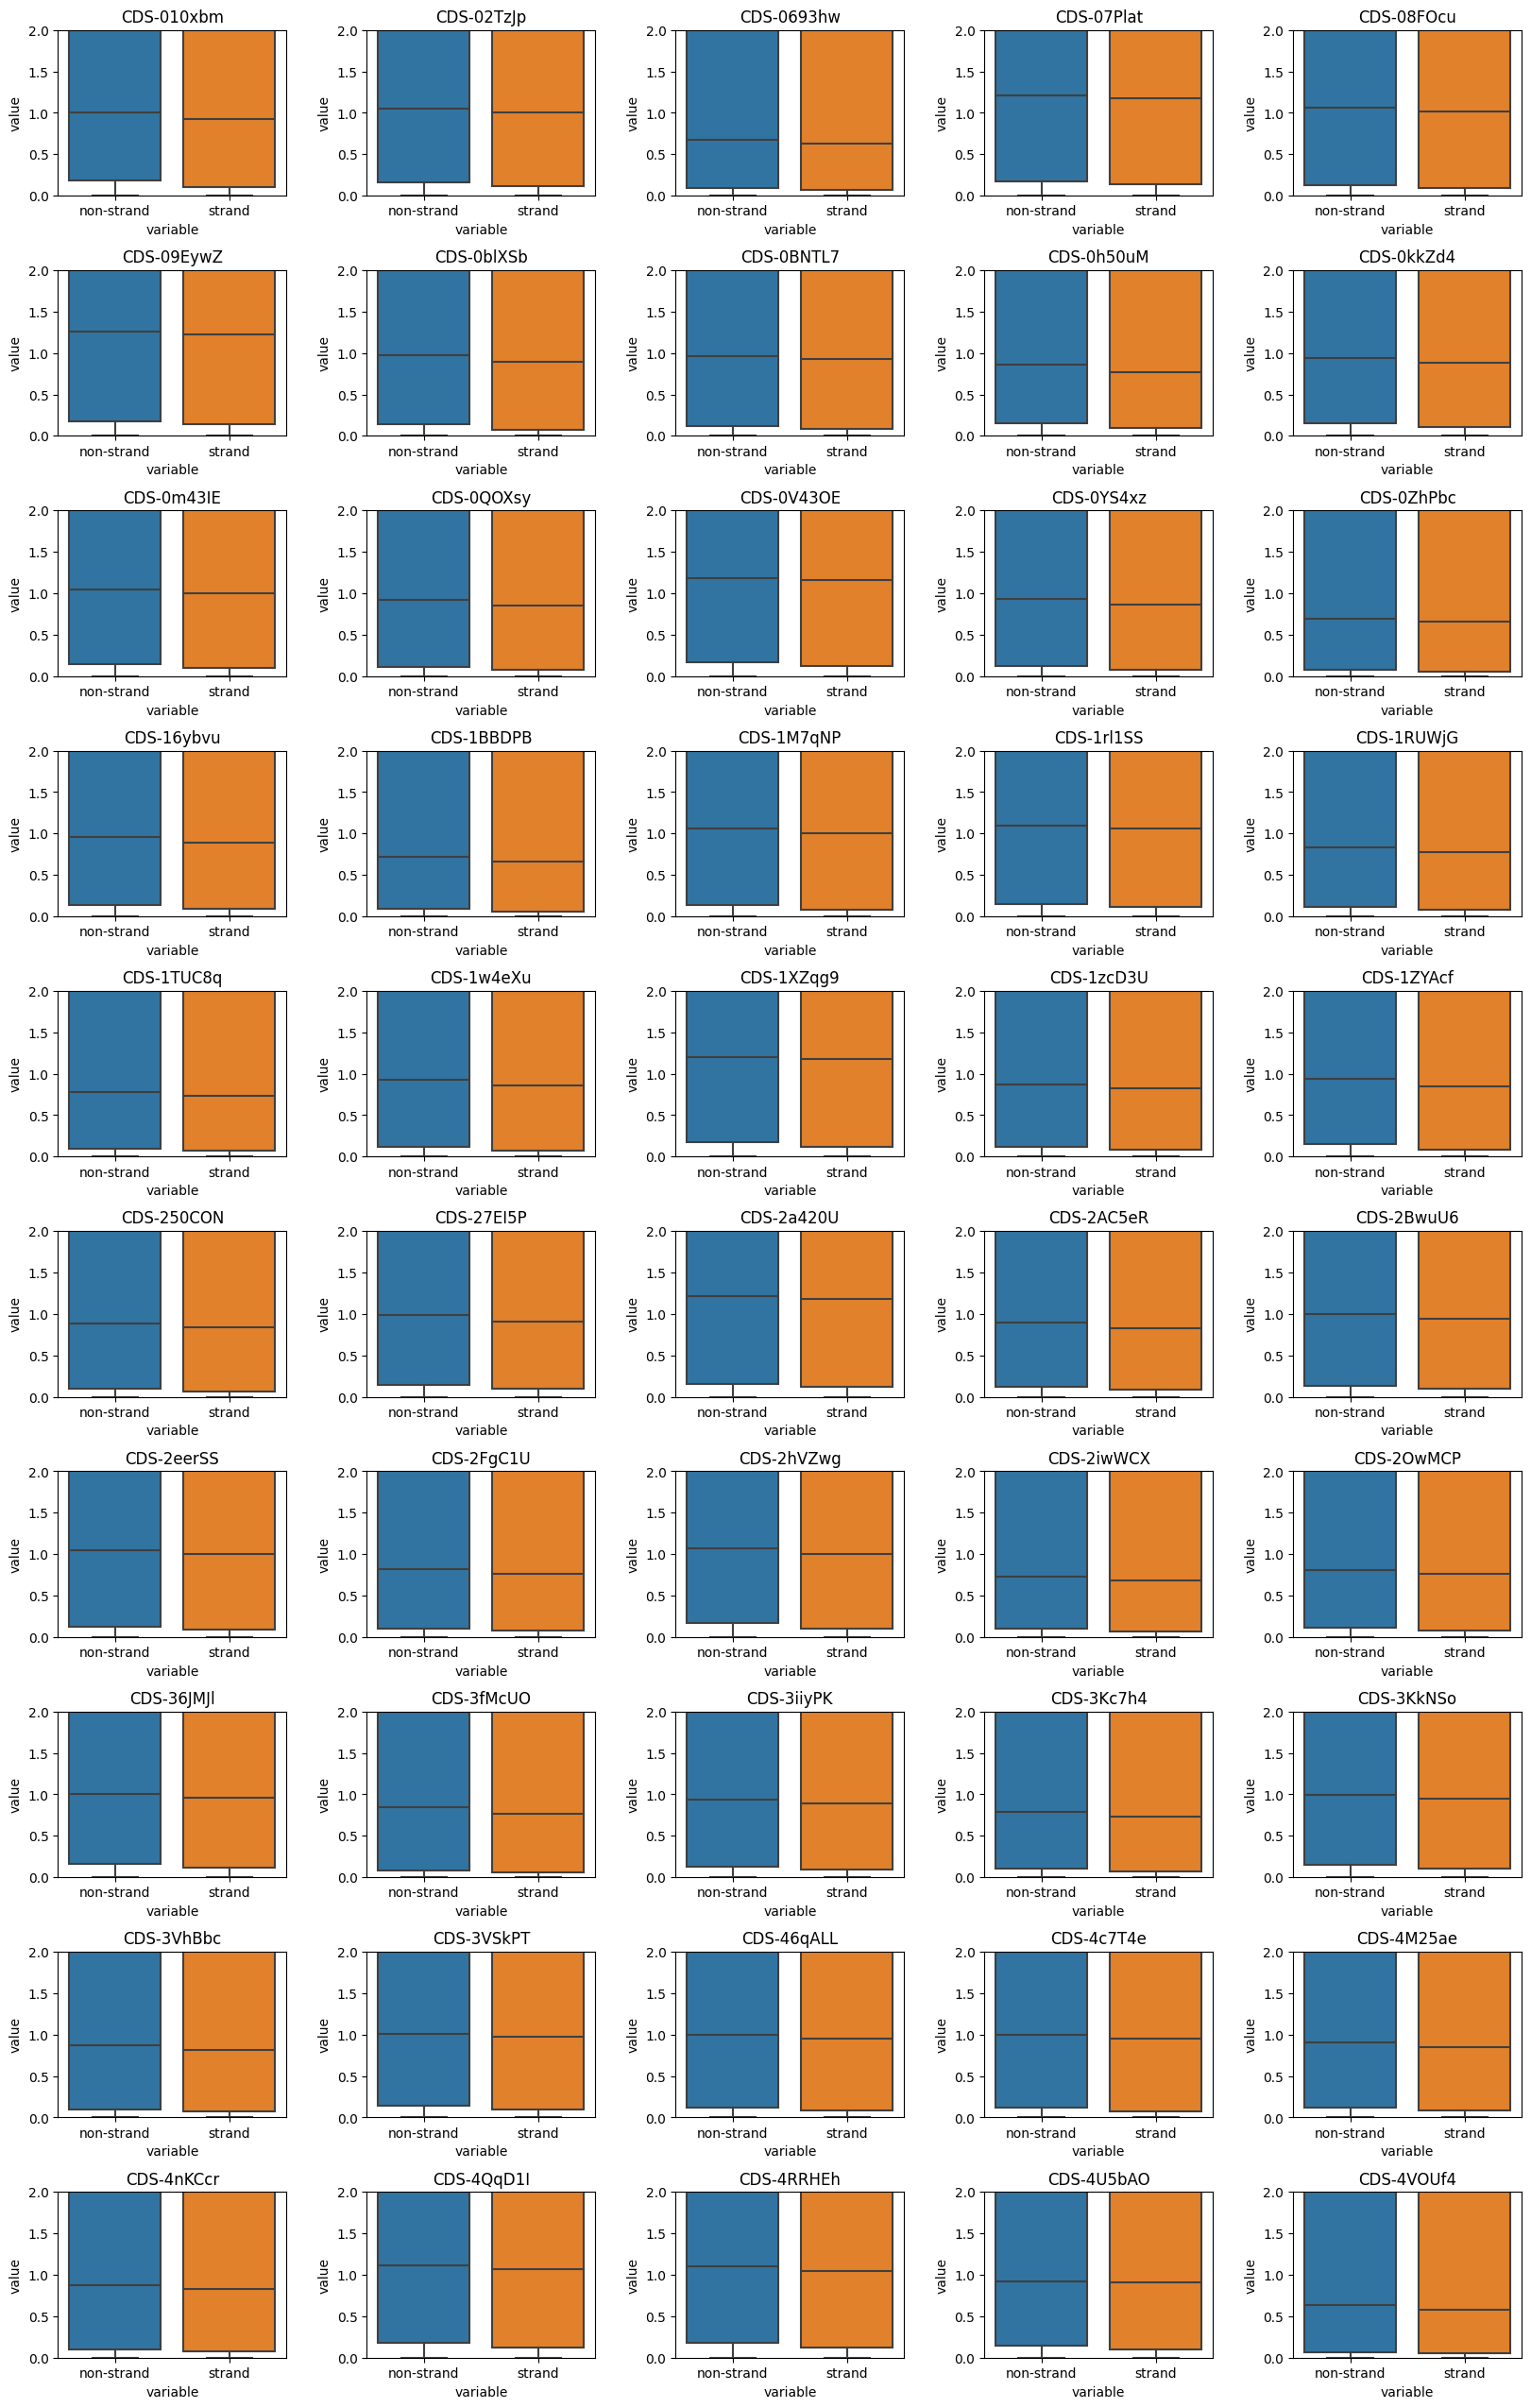

In [23]:
fig, ax = plt.subplots(10, 5)
fig.set_size_inches(20, 32)
ax = ax.flatten()
log2fc_all = []
union_prot_names = []

for row in range(50):
    df2 = pd.read_table(paired_data.iloc[row][2]).loc[:, ['gene_id', 'TPM']]
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']]
    df2.loc[:, 'TPM'] = np.log1p(df2.loc[:, 'TPM'])
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])

    merged_data = pd.merge(df2, df1, on='gene_id')
    merged_data.columns = ['sample_id', 'non-strand', 'strand']
    merged_data = merged_data.set_index("sample_id")
    #print(merged_data.head())

    merged_data = merged_data.loc[merged_data.sum(axis=1) != 0, :]
    log2fc = merged_data.iloc[:, 0] -  merged_data.iloc[:, 1]
    zero_change = sum((merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0))

    zero_prot = len(np.intersect1d(merged_data.index[(merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0)].map(lambda x:x.split('.')[0]),
                      protcod_ensem))
    print(zero_prot)

    union_prot_names += list(np.intersect1d(merged_data.index[(merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0)].map(lambda x:x.split('.')[0]), protcod_ensem))
    log2fc_all.append([paired_data.iloc[row].sample_id, zero_change, zero_prot,
                       (log2fc>=1).sum(), (log2fc<=-1).sum(), merged_data.shape[0]])
    sns.boxplot(data=merged_data.melt(ignore_index=False), x='variable', y='value', ax=ax[row])
    #sns.kdeplot(data=merged_data, ax=ax[row])
    #plotting.density_scatter(merged_data.loc[:, 'non-strand'], merged_data.loc[:, 'strand'], ax=ax[row], s=3)
    ax[row].set_title(paired_data.iloc[row].sample_id)
    ax[row].set_ylim(0, 2)
fig.subplots_adjust(wspace=0.35, hspace=0.45)

In [24]:
union_prot_names = list(set(union_prot_names))

In [25]:
len(union_prot_names), len(protcod_ensem)

(3199, 21704)

In [26]:
len(union_prot_names) / len(protcod_ensem)

0.1473921857722079

In [27]:
log2fc_all = pd.DataFrame(log2fc_all)

In [28]:
log2fc_all.head()

0     1    2    3  4      5
0  CDS-010xbm  2868  475  297  6  26781
1  CDS-02TzJp  1630  263  173  7  24867
2  CDS-0693hw  1605  195  157  4  26754
3  CDS-07Plat  1309  247  154  7  22728
4  CDS-08FOcu  1475  283  143  5  22599

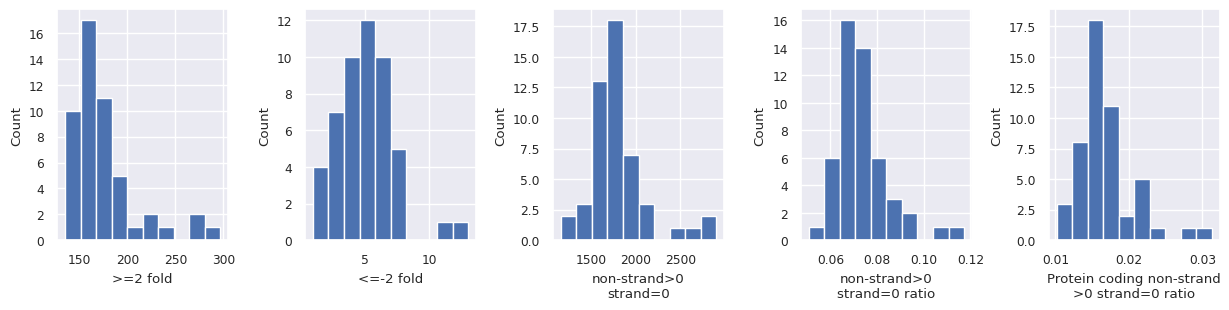

In [29]:
sns.set('talk')
sns.set(font_scale=0.8)  

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(15, 3)
ax[0].hist(log2fc_all.iloc[:, 3], bins=10)
ax[0].set_xlabel(">=2 fold")
ax[0].set_ylabel("Count")
ax[1].hist(log2fc_all.iloc[:, 4], bins=10)
ax[1].set_xlabel("<=-2 fold")
ax[1].set_ylabel("Count")

ax[2].hist(log2fc_all.iloc[:, 1], bins=10)
ax[2].set_xlabel("non-strand>0\nstrand=0")
ax[2].set_ylabel("Count")
ax[3].hist(log2fc_all.iloc[:, 1] / log2fc_all.iloc[:, 5], bins=10)
ax[3].set_xlabel("non-strand>0\nstrand=0 ratio")
ax[3].set_ylabel("Count")
ax[4].hist(log2fc_all.iloc[:, 2] / 19193, bins=10)
ax[4].set_xlabel("Protein coding non-strand\n>0 strand=0 ratio")
ax[4].set_ylabel("Count")
fig.subplots_adjust(wspace=0.45)

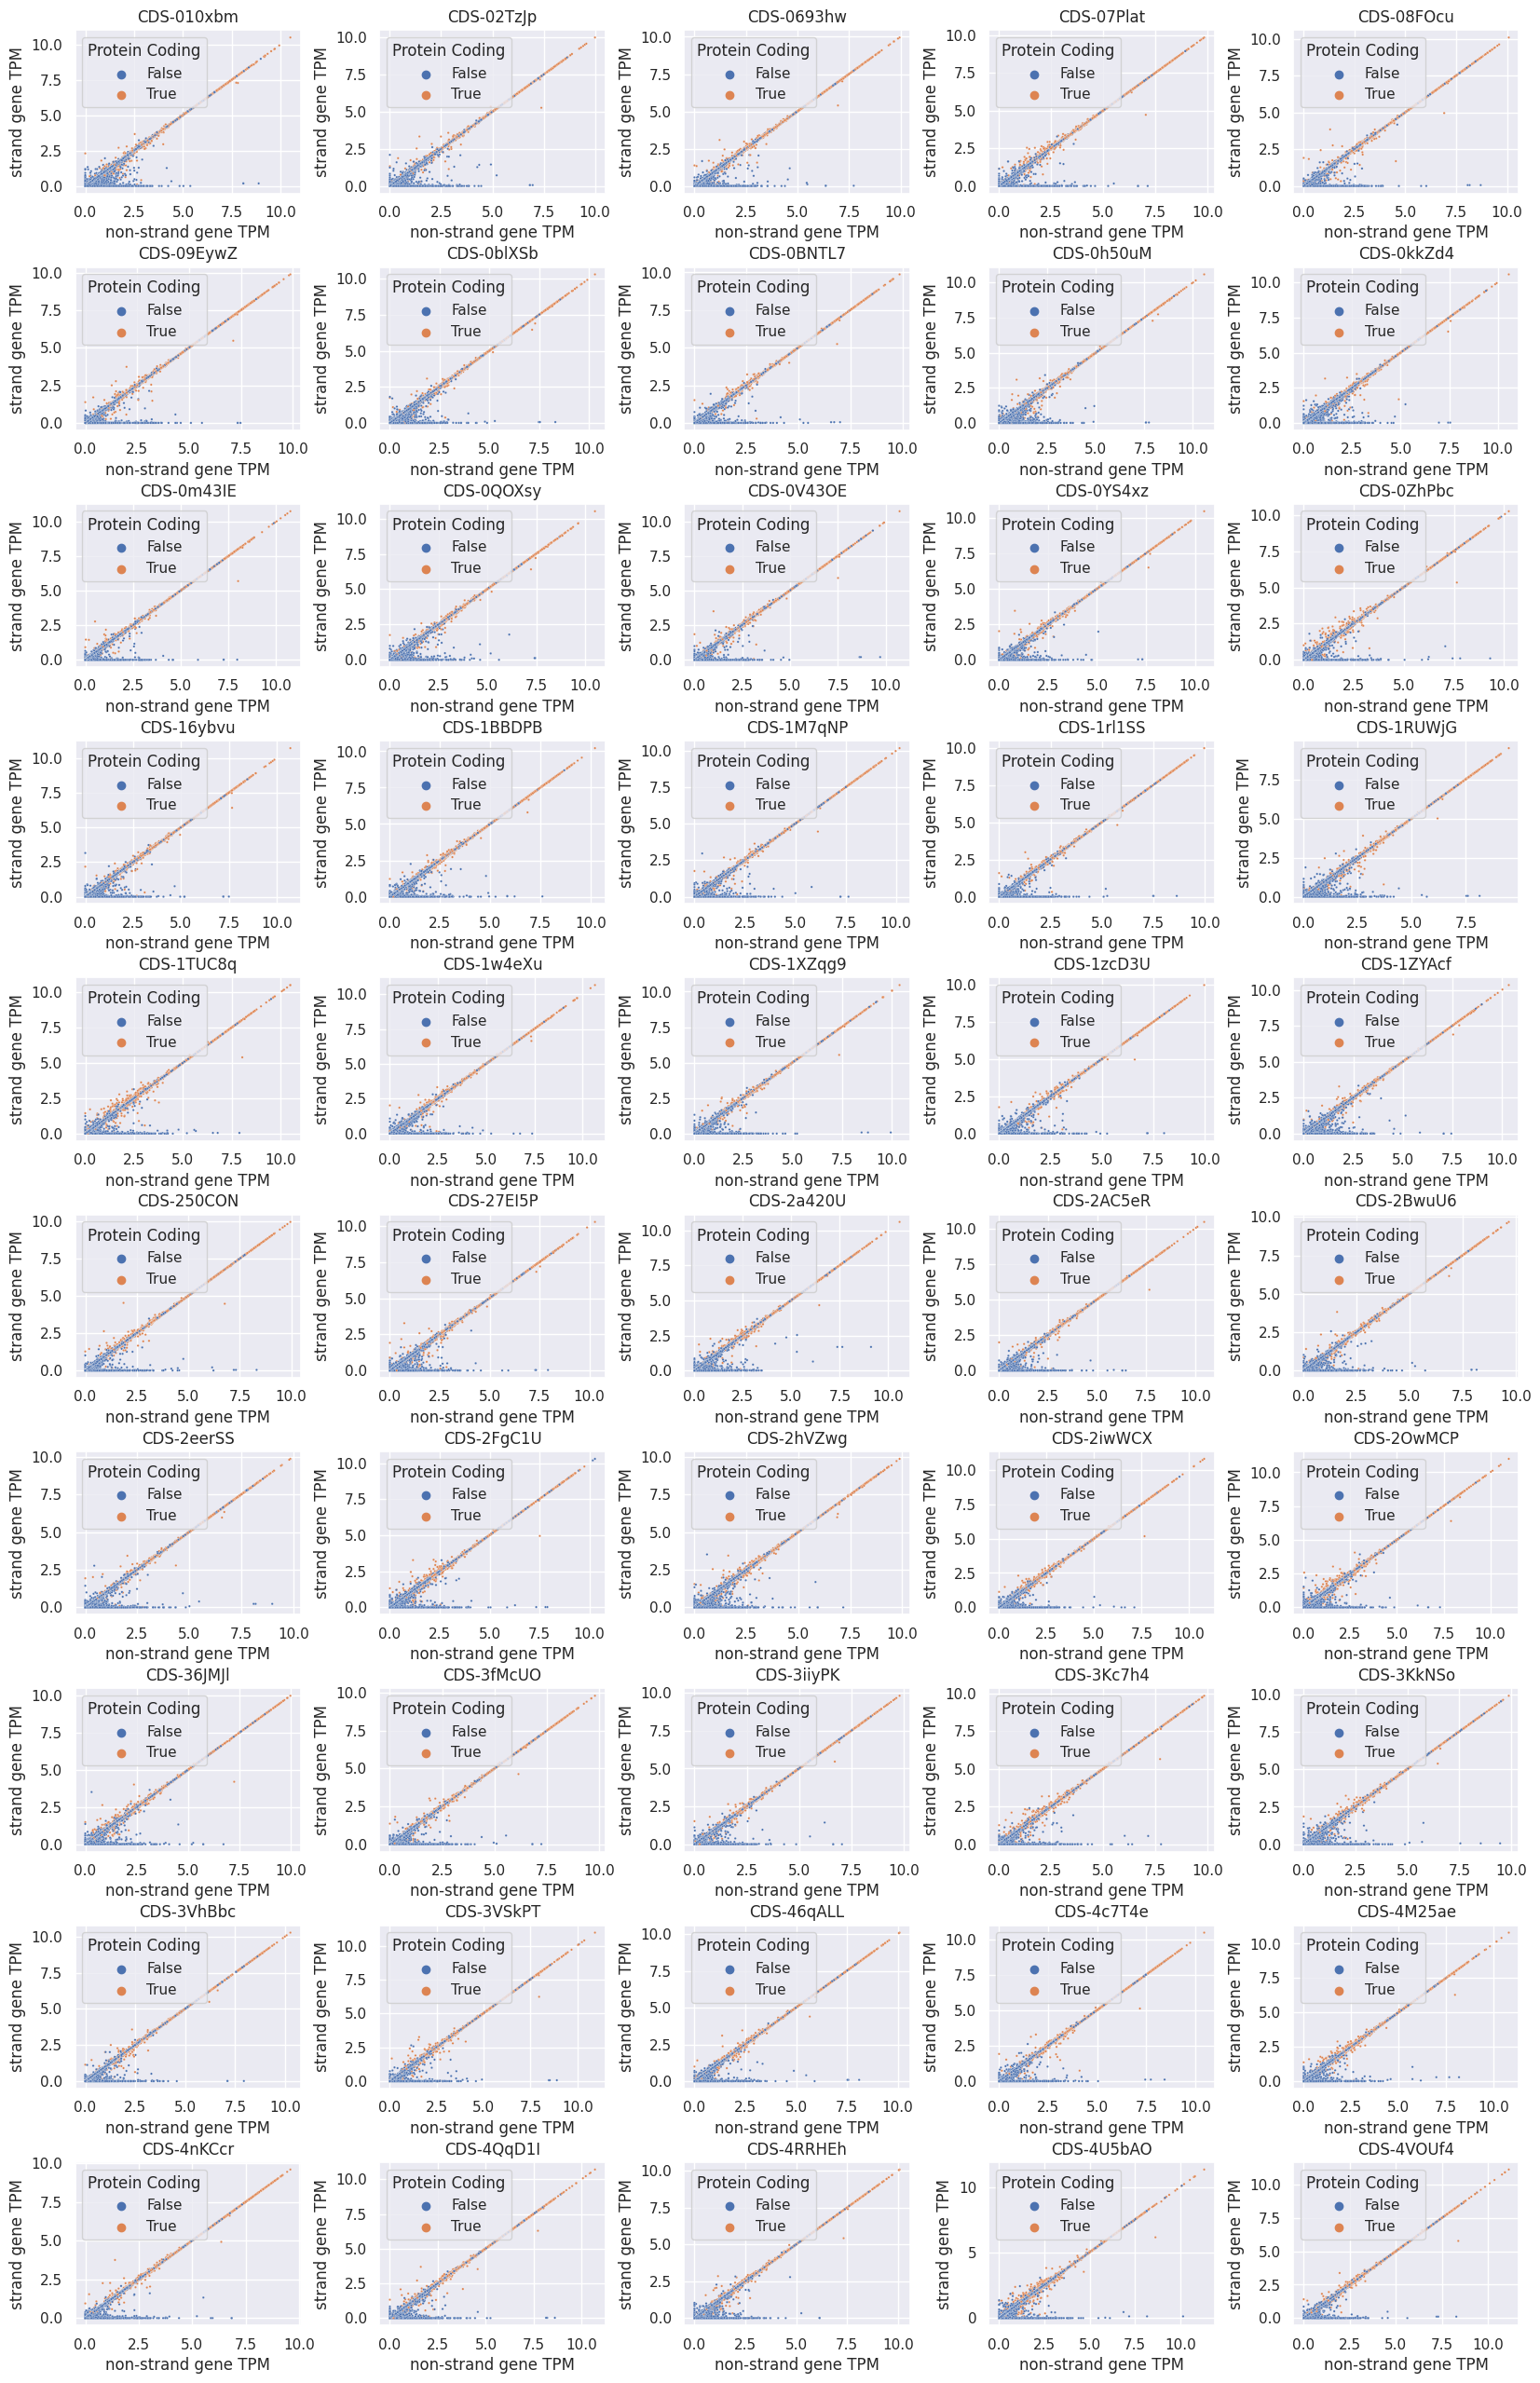

In [30]:
sns.set("talk")
sns.set(font_scale=1)  # crazy big

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(20, 32)
ax = ax.flatten()
for row in range(50):
    df2 = pd.read_table(paired_data.iloc[row][2]).loc[:, ['gene_id', 'TPM']]
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']]
    df2.loc[:, 'TPM'] = np.log1p(df2.loc[:, 'TPM'])
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])

    merged_data = pd.merge(df2, df1, on='gene_id')
    merged_data.loc[:, 'proteincoding'] = merged_data.gene_id.map(lambda x:x.split('.')[0]).isin(protcod_ensem)
    #print(merged_data.loc[:, 'proteincoding'].sum())
    merged_data.columns = ['gene_id', 'non-strand gene TPM', 'strand gene TPM', 'Protein Coding']
    #print((merged_data.loc[:, 'strand gene TPM'] - merged_data.loc[:, 'non-strand gene TPM']).sort_values())
    sns.scatterplot(data=merged_data, x='non-strand gene TPM', y='strand gene TPM', hue='Protein Coding', ax=ax[row], s=3)
    #plotting.density_scatter(merged_data.loc[:, 'non-strand'], merged_data.loc[:, 'strand'], ax=ax[row], s=3)
    ax[row].set_title(paired_data.iloc[row].sample_id)

fig.subplots_adjust(wspace=0.35, hspace=0.45)

## PCA and UMAP comparison of two products

In [26]:
!pip install numpy==1.24

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packag

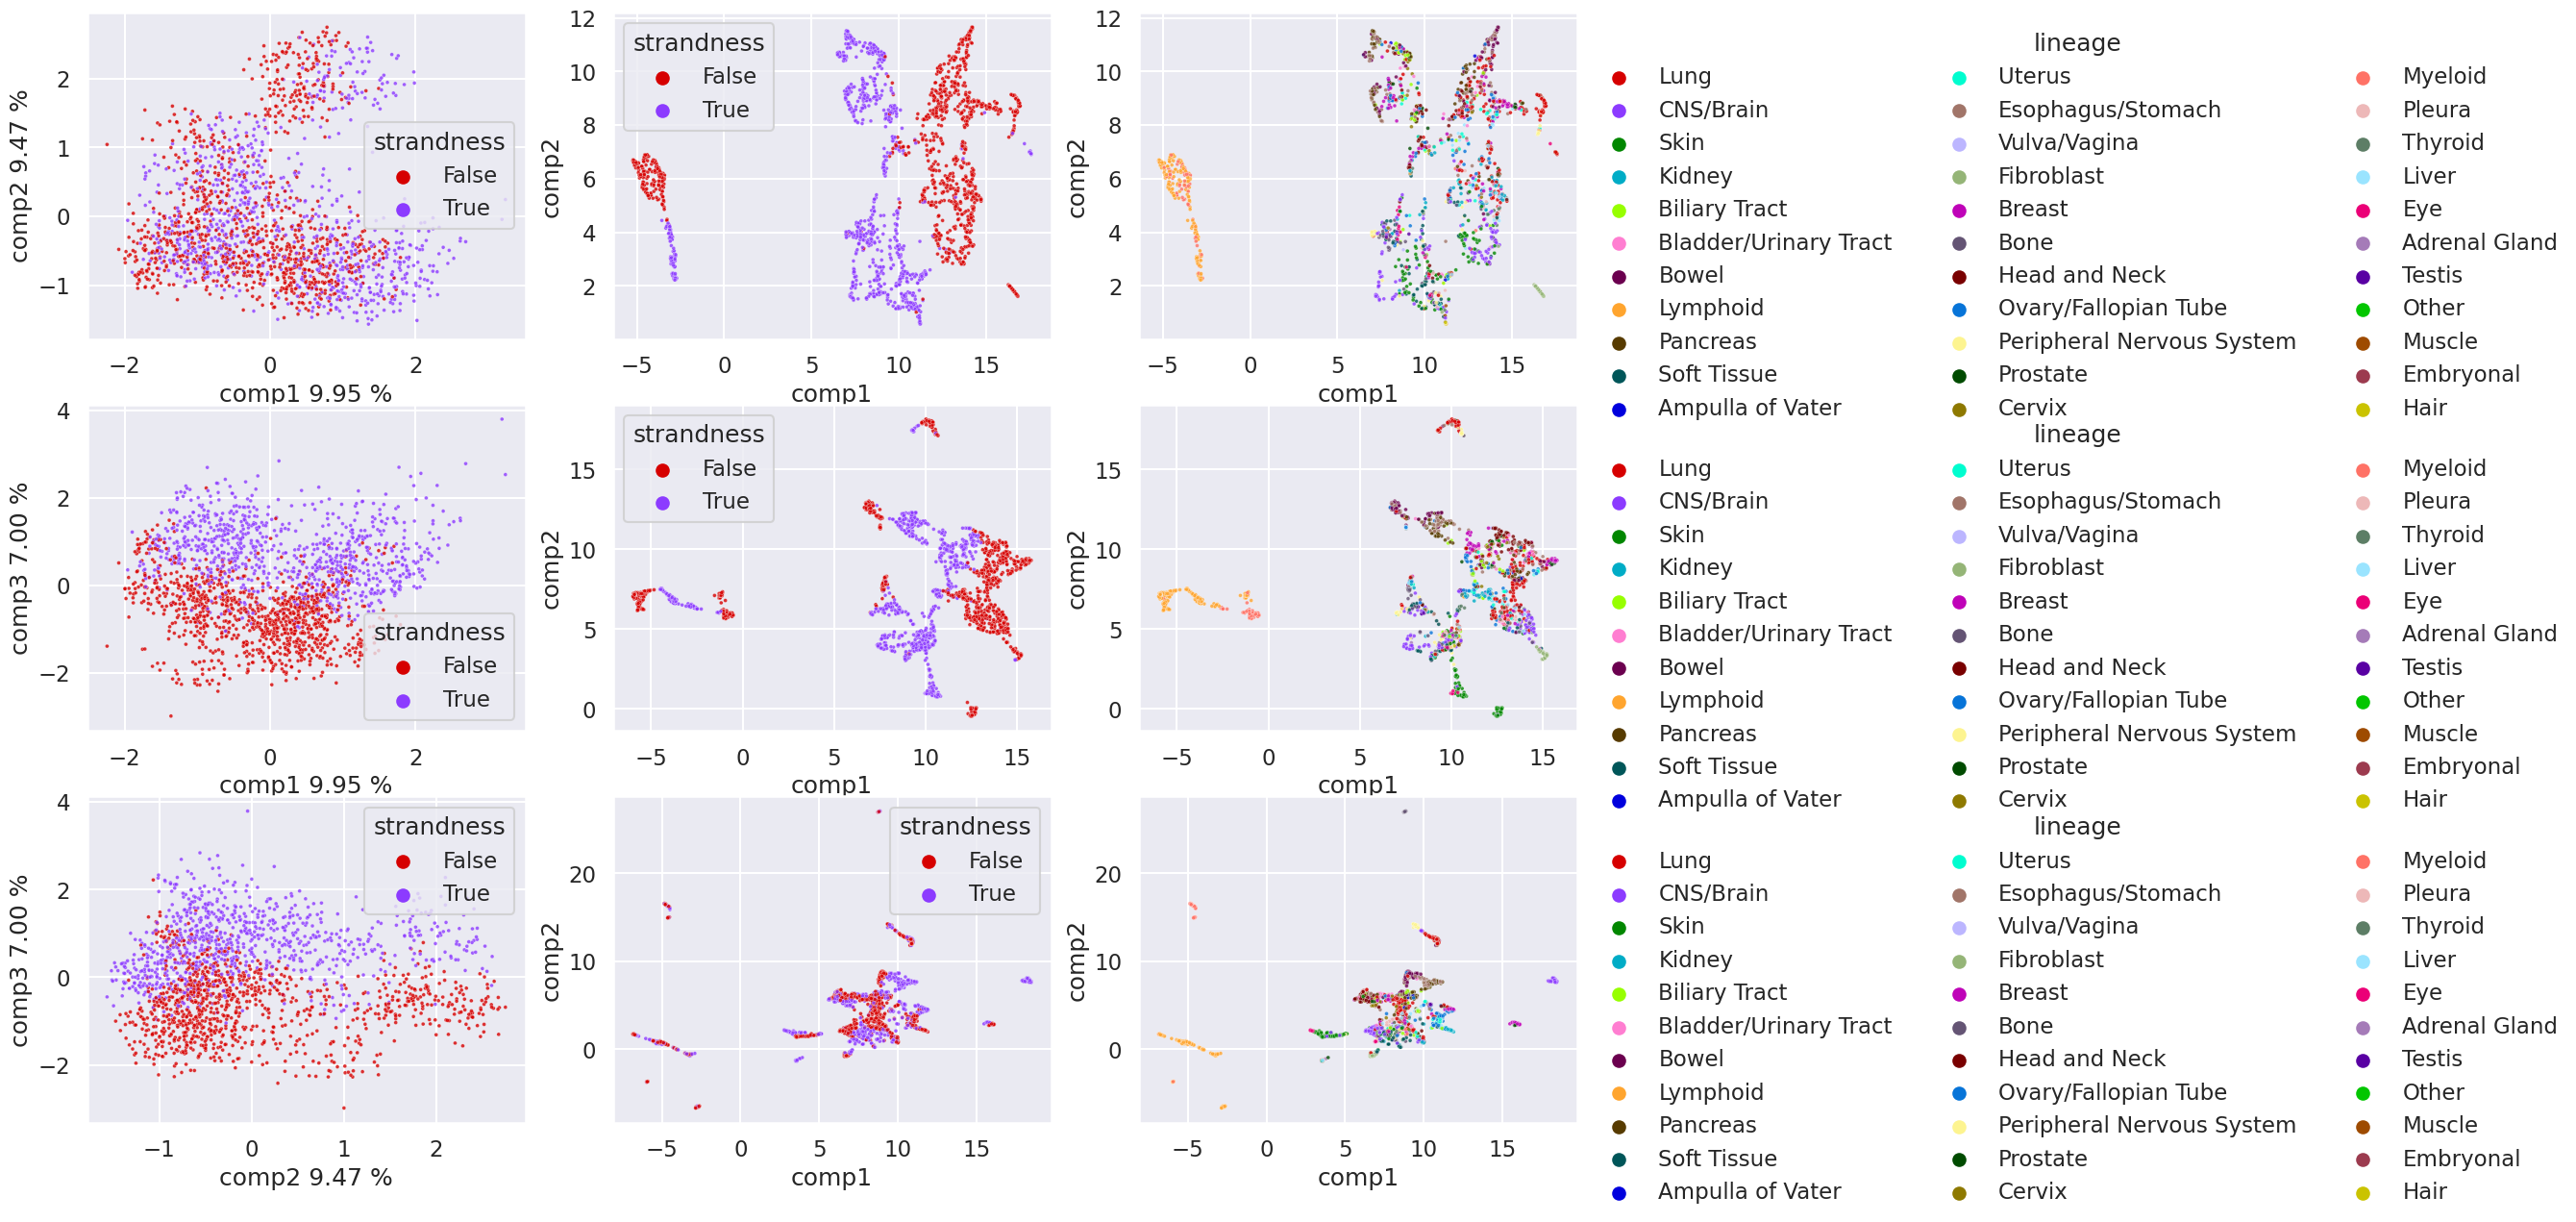

In [27]:
sns.set(font_scale=1.5)  # crazy big
sns.set("talk")

from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(20, 15)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(OmicsExpressionAllGenesTPMLogp1Profile)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)

## Add strand-specifc rsem results into the PCA/UMAP

In [28]:
df1s = []
for row in range(50):
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']].set_index("gene_id")
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])
    df1.columns = [paired_data.iloc[row][0]]
    df1s.append(df1)

In [29]:
df1s = pd.concat(df1s, axis=1)

In [30]:
df1s.head()

CDS-010xbm  CDS-02TzJp  CDS-0693hw  CDS-07Plat  \
gene_id                                                              
ENSG00000000003.15    3.022861    3.173878    2.190536    3.298426   
ENSG00000000005.6     0.000000    0.405465    0.000000    0.000000   
ENSG00000000419.14    5.124500    4.932962    5.121043    4.345492   
ENSG00000000457.14    1.991976    1.788421    1.662030    1.214913   
ENSG00000000460.17    3.117507    2.437990    2.943386    1.965713   

                    CDS-08FOcu  CDS-09EywZ  CDS-0blXSb  CDS-0BNTL7  \
gene_id                                                              
ENSG00000000003.15    2.954389    2.802754    4.108247    3.531055   
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000   
ENSG00000000419.14    3.952973    4.633660    4.713666    4.963054   
ENSG00000000457.14    1.456287    1.504077    2.303585    1.806648   
ENSG00000000460.17    1.128171    2.089392    2.143589    2.136531   

                    CDS-0h50uM  CDS-0kkZd4  ...  CDS-3VhBbc  CDS-3VSkPT  \
gene_id                                     ...                           
ENSG00000000003.15    3.080073    1.444563  ...    0.000000    0.425268   
ENSG00000000005.6     0.322083    0.000000  ...    0.000000    0.000000   
ENSG00000000419.14    5.119908    4.586395  ...    3.666634    3.701055   
ENSG00000000457.14    1.566530    1.662030  ...    1.978239    1.418277   
ENSG00000000460.17    2.877512    2.845491  ...    1.990610    1.481605   

                    CDS-46qALL  CDS-4c7T4e  CDS-4M25ae  CDS-4nKCcr  \
gene_id                                                              
ENSG00000000003.15    3.335414    3.448717    2.639057    2.471484   
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000   
ENSG00000000419.14    4.786241    4.371724    4.367420    5.148134   
ENSG00000000457.14    1.595339    1.488400    1.252763    1.423108   
ENSG00000000460.17    1.974081    2.783776    2.140066    2.930660   

                    CDS-4QqD1I  CDS-4RRHEh  CDS-4U5bAO  CDS-4VOUf4  
gene_id                                                             
ENSG00000000003.15    2.321407    3.003204    2.826722    3.120160  
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000  
ENSG00000000419.14    4.427836    5.003544    3.128513    4.452369  
ENSG00000000457.14    1.007958    1.675226    1.451614    1.638997  
ENSG00000000460.17    2.422144    3.172203    1.528228    1.830980  

[5 rows x 50 columns]

In [31]:
gene_ids = df1s.index.map(lambda x:x.split('.')[0]).map(allgenes_rename).values
gene_ids[pd.isnull(gene_ids)] = df1s.index[pd.isnull(gene_ids)].map(lambda x:x.split('.')[0])

In [32]:
gene_ids.shape

(60649,)

In [33]:
df1s.index = gene_ids
df1s = df1s.T

In [34]:
df1s.head()

TSPAN6 (ENSG00000000003)  TNMD (ENSG00000000005)  \
CDS-010xbm                  3.022861                0.000000   
CDS-02TzJp                  3.173878                0.405465   
CDS-0693hw                  2.190536                0.000000   
CDS-07Plat                  3.298426                0.000000   
CDS-08FOcu                  2.954389                0.000000   

            DPM1 (ENSG00000000419)  SCYL3 (ENSG00000000457)  \
CDS-010xbm                5.124500                 1.991976   
CDS-02TzJp                4.932962                 1.788421   
CDS-0693hw                5.121043                 1.662030   
CDS-07Plat                4.345492                 1.214913   
CDS-08FOcu                3.952973                 1.456287   

            C1orf112 (ENSG00000000460)  FGR (ENSG00000000938)  \
CDS-010xbm                    3.117507               0.019803   
CDS-02TzJp                    2.437990               0.000000   
CDS-0693hw                    2.943386               0.039221   
CDS-07Plat                    1.965713               0.029559   
CDS-08FOcu                    1.128171               0.000000   

            CFH (ENSG00000000971)  FUCA2 (ENSG00000001036)  \
CDS-010xbm               0.862890                 2.125848   
CDS-02TzJp               0.131028                 2.650421   
CDS-0693hw               0.912283                 4.642177   
CDS-07Plat               3.303217                 4.571510   
CDS-08FOcu               5.031548                 4.138361   

            GCLC (ENSG00000001084)  NFYA (ENSG00000001167)  ...  \
CDS-010xbm                4.526019                3.306520  ...   
CDS-02TzJp                2.933857                2.418589  ...   
CDS-0693hw                2.559550                2.275214  ...   
CDS-07Plat                3.865141                2.225704  ...   
CDS-08FOcu                3.201526                2.041220  ...   

            ENSG00000288716  ENSG00000288717  ENSG00000288718  \
CDS-010xbm              0.0         0.378436         0.000000   
CDS-02TzJp              0.0         0.615186         0.000000   
CDS-0693hw              0.0         0.000000         0.058269   
CDS-07Plat              0.0         0.000000         0.000000   
CDS-08FOcu              0.0         0.307485         0.000000   

            ENSG00000288719  ENSG00000288720  ENSG00000288721  \
CDS-010xbm         0.019803              0.0         0.703098   
CDS-02TzJp         0.009950              0.0         0.300105   
CDS-0693hw         0.000000              0.0         0.262364   
CDS-07Plat         0.000000              0.0         0.122218   
CDS-08FOcu         0.000000              0.0         0.173953   

            ENSG00000288722  ENSG00000288723  ENSG00000288724  ENSG00000288725  
CDS-010xbm         1.955860         0.104360              0.0         0.000000  
CDS-02TzJp         2.068128         0.039221              0.0         0.048790  
CDS-0693hw         1.178655         0.058269              0.0         0.000000  
CDS-07Plat         2.794839         0.000000              0.0         0.000000  
CDS-08FOcu         2.104134         0.000000              0.0         0.058269  

[5 rows x 60649 columns]

In [35]:
OmicsExpressionAllGenesTPMLogp1Profile.head()

TSPAN6 (ENSG00000000003)  TNMD (ENSG00000000005)  \
PR-AdBjpG                  4.331992                0.000000   
PR-I2AzwG                  4.567424                0.584963   
PR-5ekAAC                  3.150560                0.000000   
PR-DuAy1L                  4.240314                0.000000   
PR-pGHJuj                  4.032101                0.000000   

           DPM1 (ENSG00000000419)  SCYL3 (ENSG00000000457)  \
PR-AdBjpG                7.364660                 2.792855   
PR-I2AzwG                7.106641                 2.543496   
PR-5ekAAC                7.379118                 2.333424   
PR-DuAy1L                5.681168                 2.063503   
PR-pGHJuj                6.674687                 2.117695   

           C1orf112 (ENSG00000000460)  FGR (ENSG00000000938)  \
PR-AdBjpG                    4.471187               0.028569   
PR-I2AzwG                    3.504620               0.000000   
PR-5ekAAC                    4.228049               0.056584   
PR-DuAy1L                    1.641546               0.000000   
PR-pGHJuj                    3.003602               0.000000   

           CFH (ENSG00000000971)  FUCA2 (ENSG00000001036)  \
PR-AdBjpG               1.226509                 3.044394   
PR-I2AzwG               0.189034                 3.813525   
PR-5ekAAC               1.310340                 6.687201   
PR-DuAy1L               7.236301                 5.948367   
PR-pGHJuj               2.169925                 6.838195   

           GCLC (ENSG00000001084)  NFYA (ENSG00000001167)  ...  \
PR-AdBjpG                6.500005                4.739848  ...   
PR-I2AzwG                4.221877                3.481557  ...   
PR-5ekAAC                3.682573                3.273516  ...   
PR-DuAy1L                4.596935                2.918386  ...   
PR-pGHJuj                3.253989                4.276497  ...   

           ENSG00000288714  ENSG00000288717  ENSG00000288718  ENSG00000288719  \
PR-AdBjpG         0.000000         0.536053         0.000000         0.028569   
PR-I2AzwG         0.000000         0.879706         0.000000         0.014355   
PR-5ekAAC         0.028569         0.000000         0.084064         0.000000   
PR-DuAy1L         0.000000         0.432959         0.000000         0.000000   
PR-pGHJuj         0.000000         0.000000         0.189034         0.000000   

           ENSG00000288720  ENSG00000288721  ENSG00000288722  ENSG00000288723  \
PR-AdBjpG         0.176323         0.992768         2.797013         0.000000   
PR-I2AzwG         0.014355         0.432959         2.972693         0.056584   
PR-5ekAAC         0.097611         0.367371         1.695994         0.084064   
PR-DuAy1L         0.028569         0.238787         3.016140         0.000000   
PR-pGHJuj         0.000000         0.356144         4.800123         0.000000   

           ENSG00000288724  ENSG00000288725  
PR-AdBjpG              0.0         0.000000  
PR-I2AzwG              0.0         0.070389  
PR-5ekAAC              0.0         0.000000  
PR-DuAy1L              0.0         0.084064  
PR-pGHJuj              0.0         0.000000  

[5 rows x 53961 columns]

In [36]:
df1s_sub = df1s.loc[:, df1s.loc[:, OmicsExpressionAllGenesTPMLogp1Profile.columns].columns.unique()].copy()

In [37]:
df1s_sub.shape

(50, 54002)

In [38]:
df1s_sub = df1s_sub.loc[:, ~df1s_sub.columns.duplicated()]

In [39]:
#dict(zip(meta.MainSequencingID, meta.ProfileID))

In [40]:
all_include_stranded = pd.concat([OmicsExpressionAllGenesTPMLogp1Profile, df1s_sub], axis=0)

In [41]:
### lineage = OmicsExpressionAllGenesTPMLogp1Profile.index.map(profile_to_model_dict).map(model_dataset.OncotreeLineage.to_dict())

(1954,) (1954, 5)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:21: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 10)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:24: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 30)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:27: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


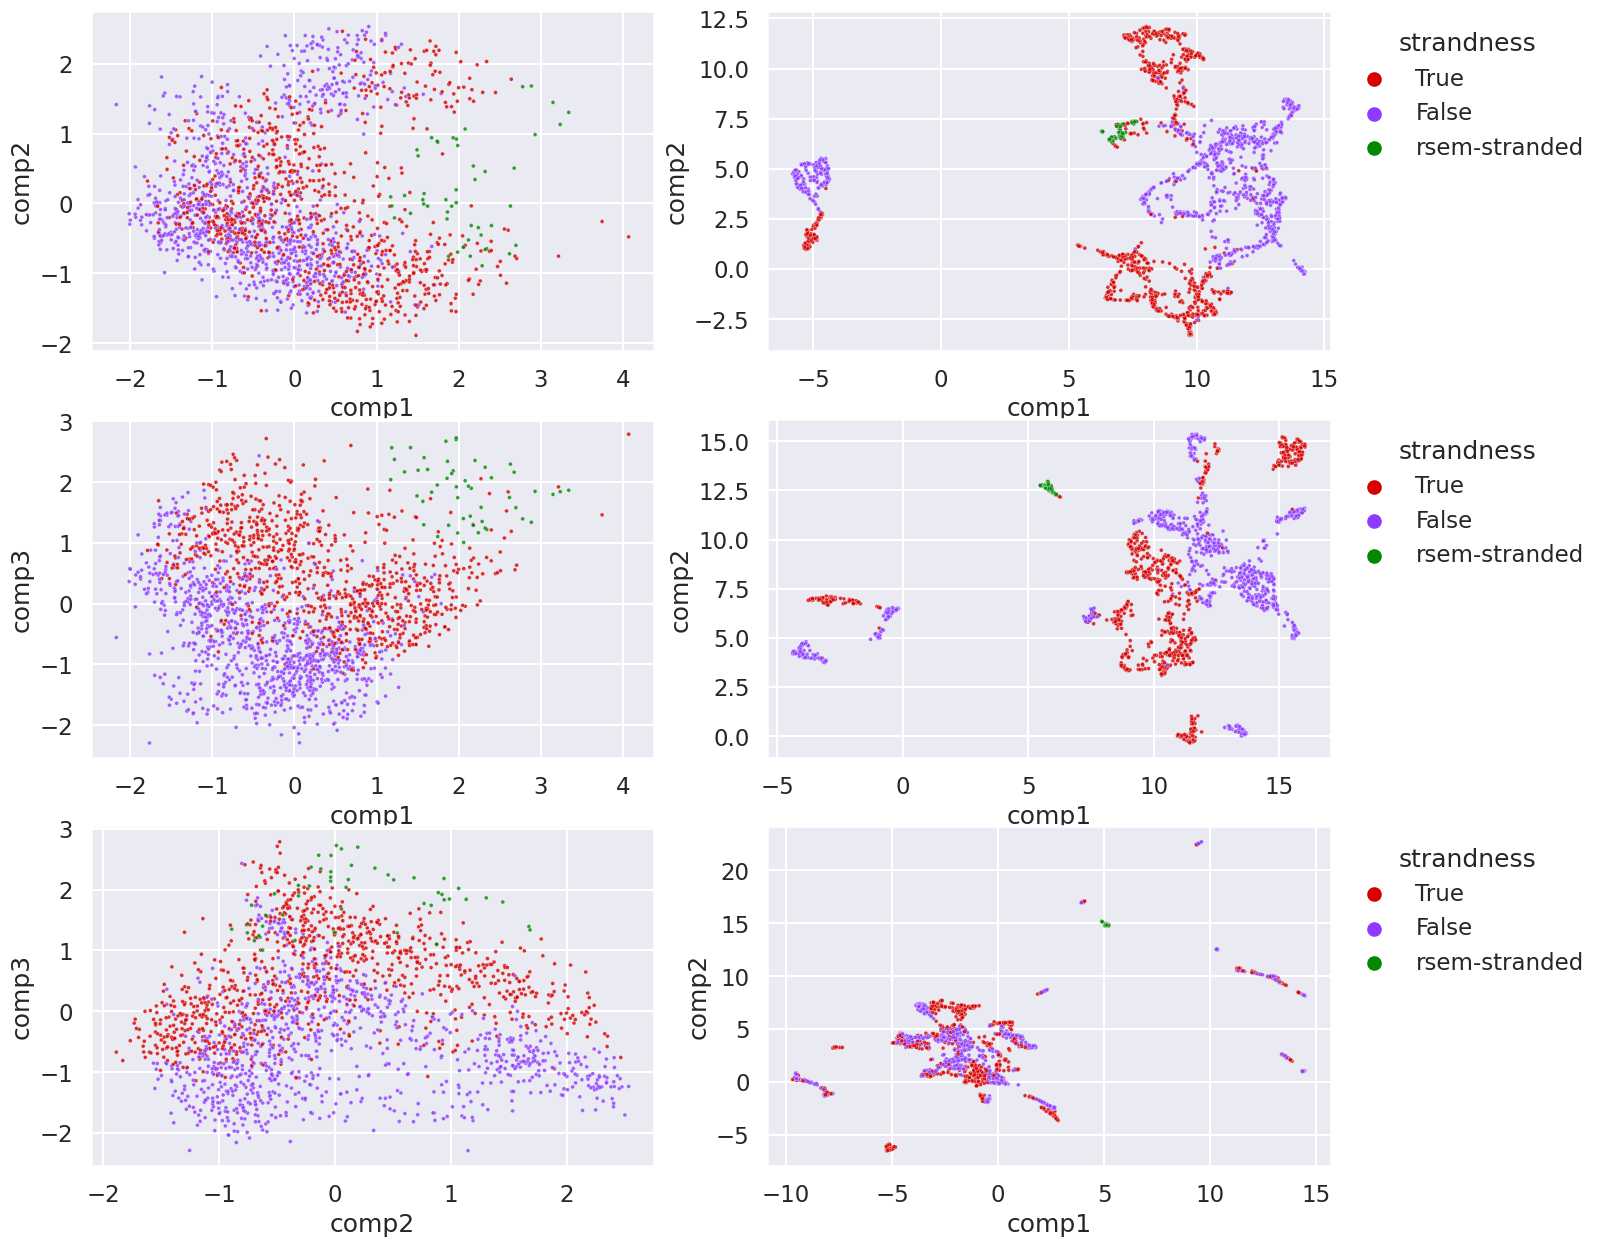

In [42]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(16, 15)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(all_include_stranded)
    strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*50])
    print(strandness.shape, components.shape)
 
    #pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], 
    #                              "strandness": strandness})
    #sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1],
                                  "strandness": strandness})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    sns.move_legend(ax[i][1], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=1)

#for i, comp_number in enumerate([5, 10, 30]):
#    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
#    components = pca.fit_transform(OmicsExpressionAllGenesTPMLogp1Profile)
#    if i == 0:
#        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
#        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
#    elif i == 1:
#        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
#        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
#    elif i == 2:
#        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
#        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
#    
#    umap_rna = u.fit_transform(components)
#    
#    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
#    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)
#
#    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
#    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

# Protein coding genes impact

In [43]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

In [44]:
OmicsExpressionAllGenesTPMLogp1Profile.shape

(1904, 19193)

In [45]:
OmicsExpressionAllGenesTPMLogp1Profile.columns

Index(['TSPAN6 (7105)', 'TNMD (64102)', 'DPM1 (8813)', 'SCYL3 (57147)',
       'C1orf112 (55732)', 'FGR (2268)', 'CFH (3075)', 'FUCA2 (2519)',
       'GCLC (2729)', 'NFYA (4800)',
       ...
       'H3C2 (8358)', 'H3C3 (8352)', 'AC098582.1 (8916)',
       'DUS4L-BCAP29 (115253422)', 'C8orf44-SGK3 (100533105)',
       'ELOA3B (728929)', 'NPBWR1 (2831)', 'ELOA3D (100506888)',
       'ELOA3 (162699)', 'CDR1 (1038)'],
      dtype='object', length=19193)

In [46]:
all_include_stranded.columns = all_include_stranded.columns.map(protcod_rename)
all_include_stranded = all_include_stranded.loc[:, ~all_include_stranded.columns.isnull()]

In [47]:
all_include_stranded.shape

(1954, 19193)

In [48]:
all_include_stranded.head()

TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
PR-AdBjpG       4.331992      0.000000     7.364660       2.792855   
PR-I2AzwG       4.567424      0.584963     7.106641       2.543496   
PR-5ekAAC       3.150560      0.000000     7.379118       2.333424   
PR-DuAy1L       4.240314      0.000000     5.681168       2.063503   
PR-pGHJuj       4.032101      0.000000     6.674687       2.117695   

           C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
PR-AdBjpG          4.471187    0.028569    1.226509      3.044394   
PR-I2AzwG          3.504620    0.000000    0.189034      3.813525   
PR-5ekAAC          4.228049    0.056584    1.310340      6.687201   
PR-DuAy1L          1.641546    0.000000    7.236301      5.948367   
PR-pGHJuj          3.003602    0.000000    2.169925      6.838195   

           GCLC (2729)  NFYA (4800)  ...  H3C2 (8358)  H3C3 (8352)  \
PR-AdBjpG     6.500005     4.739848  ...     2.689299     0.189034   
PR-I2AzwG     4.221877     3.481557  ...     1.286881     1.049631   
PR-5ekAAC     3.682573     3.273516  ...     0.594549     1.097611   
PR-DuAy1L     4.596935     2.918386  ...     0.000000     0.000000   
PR-pGHJuj     3.253989     4.276497  ...     0.238787     0.378512   

           AC098582.1 (8916)  DUS4L-BCAP29 (115253422)  \
PR-AdBjpG           0.201634                  2.130931   
PR-I2AzwG           0.321928                  1.464668   
PR-5ekAAC           0.831877                  2.946731   
PR-DuAy1L           0.847997                  1.887525   
PR-pGHJuj           0.584963                  1.748461   

           C8orf44-SGK3 (100533105)  ELOA3B (728929)  NPBWR1 (2831)  \
PR-AdBjpG                  0.555816              0.0       0.275007   
PR-I2AzwG                  0.632268              0.0       0.014355   
PR-5ekAAC                  0.475085              0.0       0.084064   
PR-DuAy1L                  0.176323              0.0       0.000000   
PR-pGHJuj                  0.839960              0.0       0.014355   

           ELOA3D (100506888)  ELOA3 (162699)  CDR1 (1038)  
PR-AdBjpG                 0.0             0.0     0.000000  
PR-I2AzwG                 0.0             0.0     0.000000  
PR-5ekAAC                 0.0             0.0     0.042644  
PR-DuAy1L                 0.0             0.0     0.000000  
PR-pGHJuj                 0.0             0.0     0.042644  

[5 rows x 19193 columns]

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/495040070.py:16: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/495040070.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/495040070.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/495040070.py:33: UserWarning: The palette list h

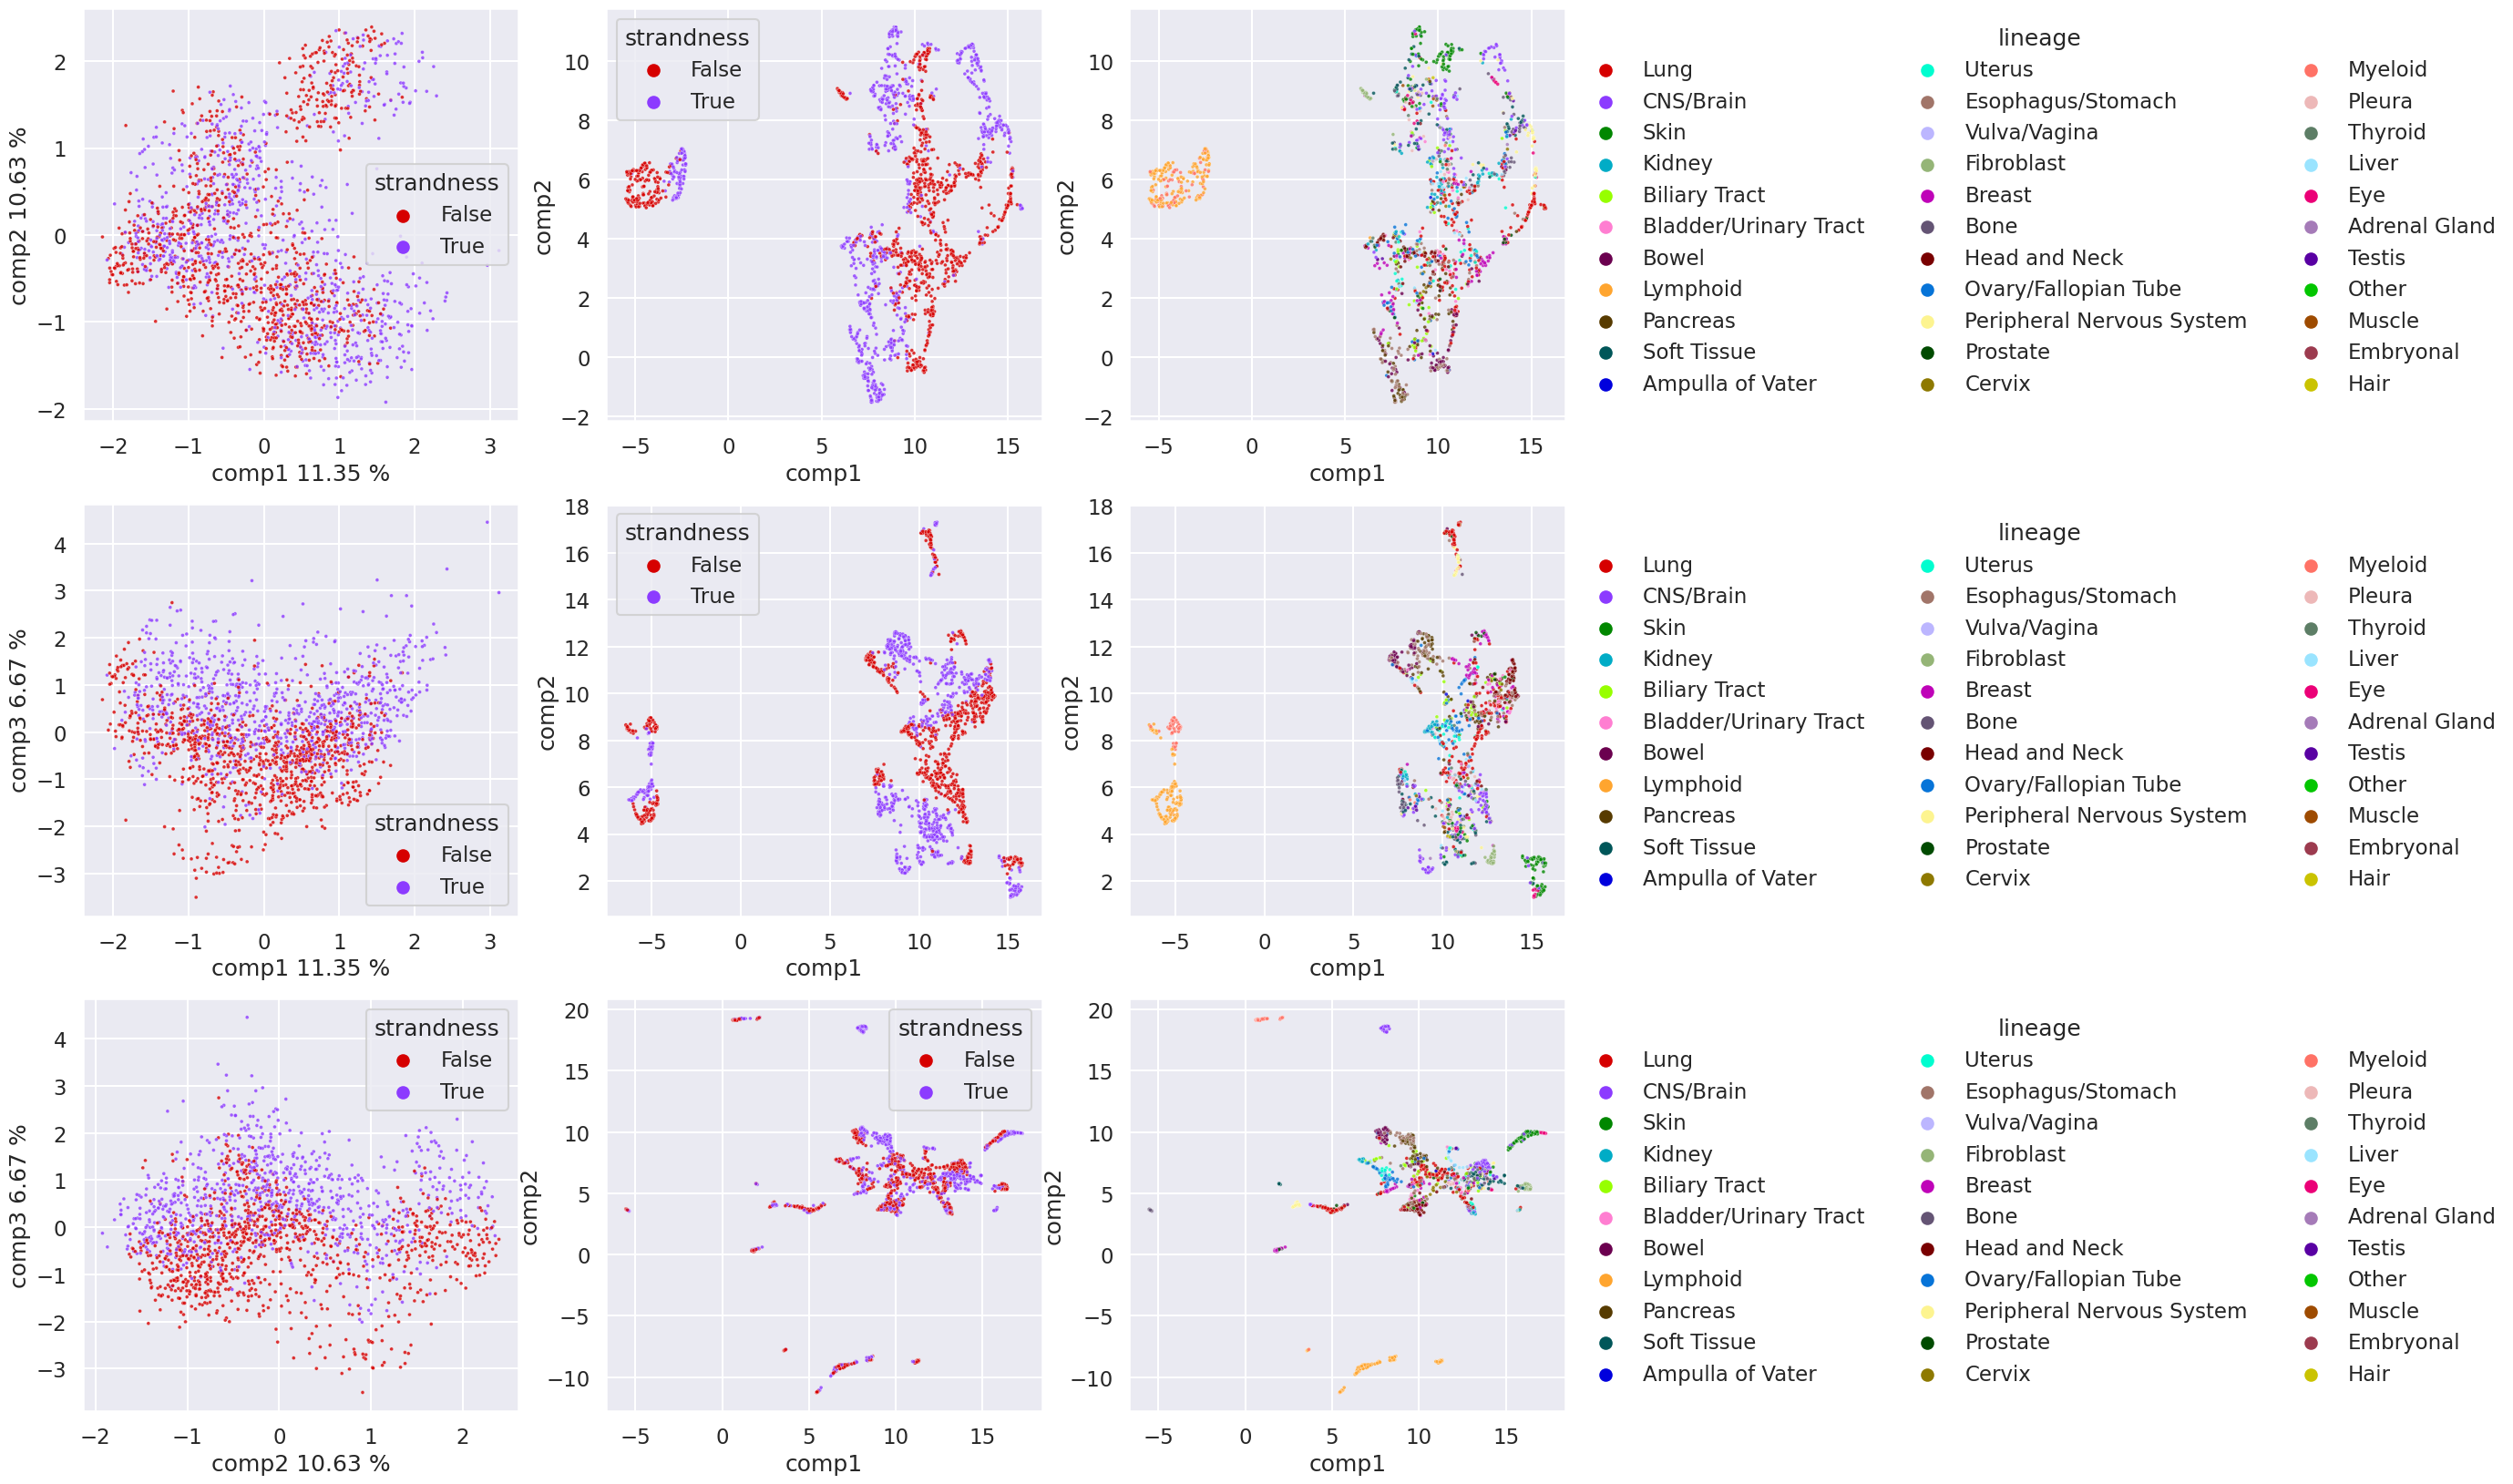

In [49]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(OmicsExpressionAllGenesTPMLogp1Profile)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


(1954,) (1954, 5)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:22: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 10)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:25: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 30)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:28: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


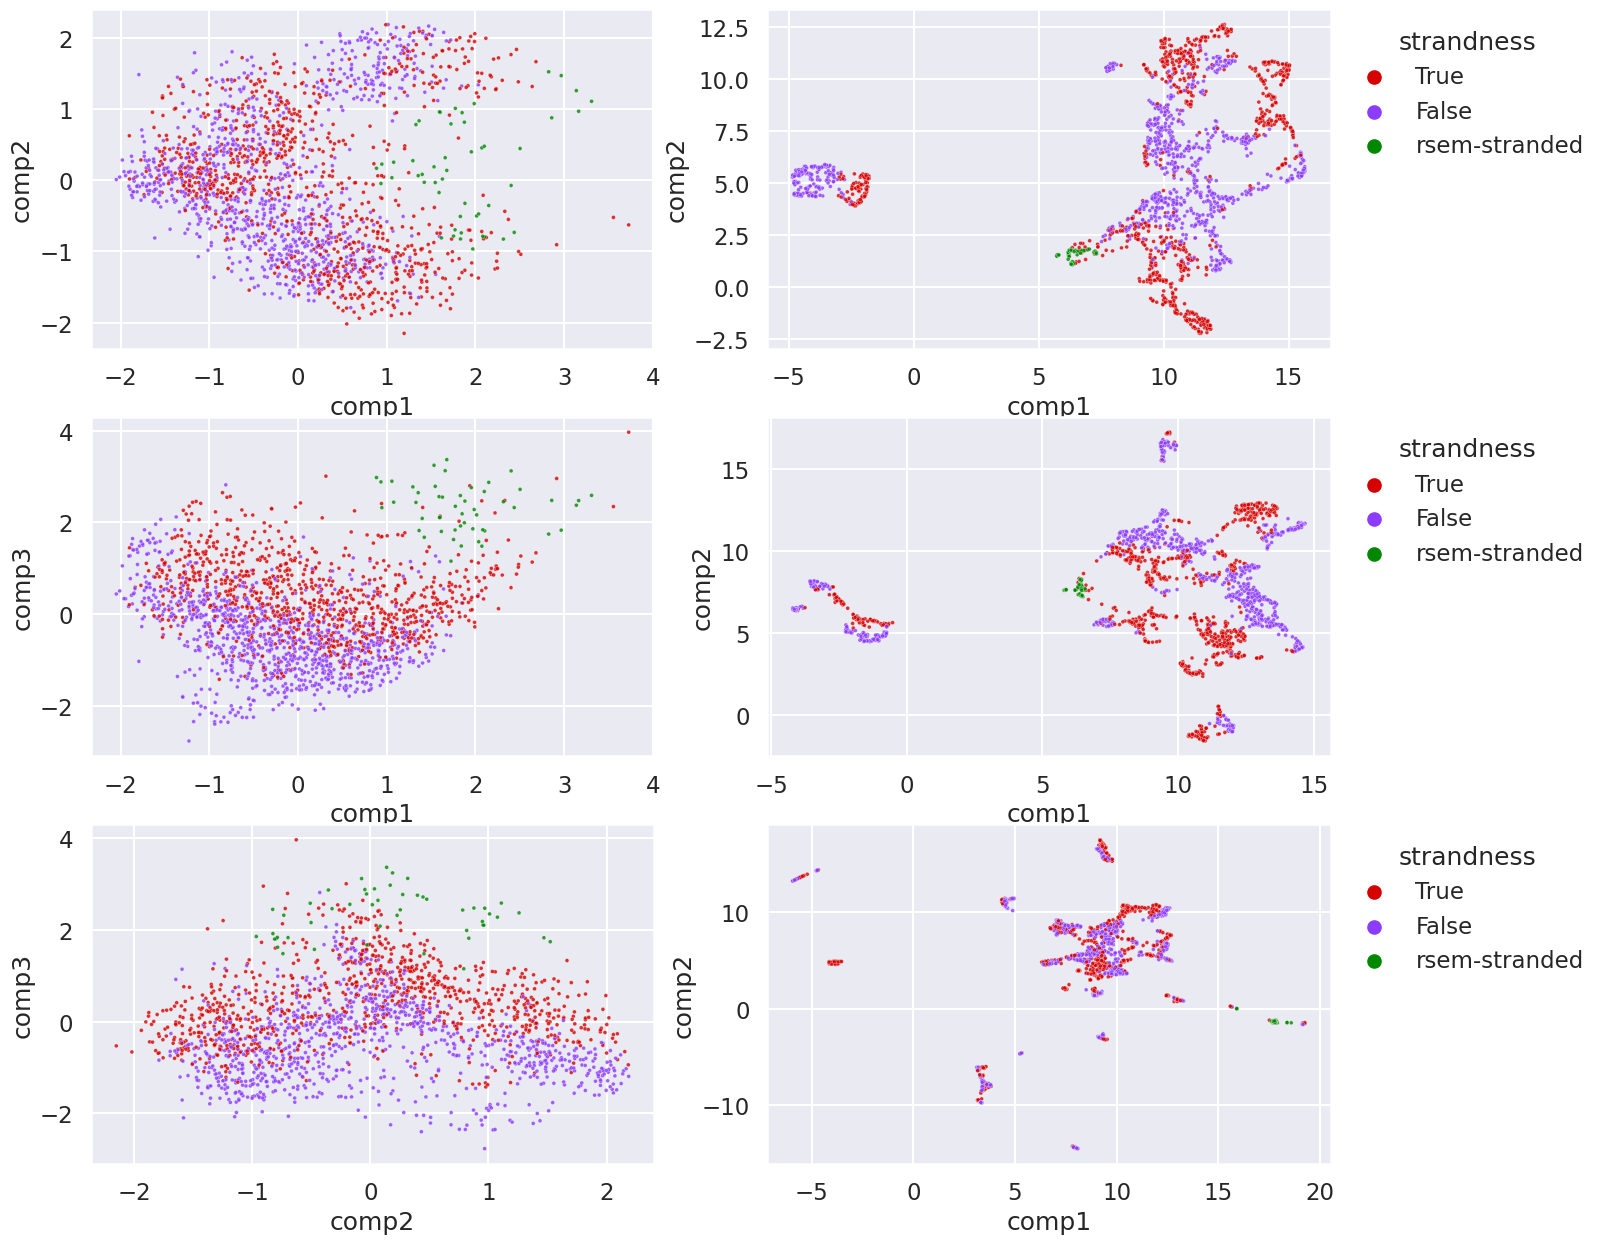

In [50]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(16, 15)


for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(all_include_stranded)
    strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*50])
    print(strandness.shape, components.shape)
 
    #pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], 
    #                              "strandness": strandness})
    #sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1],
                                  "strandness": strandness})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    sns.move_legend(ax[i][1], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=1)


In [51]:
from inmoose.pycombat import pycombat_norm, pycombat_seq


In [53]:
strandness = OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))

tpm_corrected = pycombat_norm(OmicsExpressionAllGenesTPMLogp1Profile.T, strandness)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [55]:
tpm_corrected.shape

(19193, 1904)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1375715610.py:16: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1375715610.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/1375715610.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5454/13

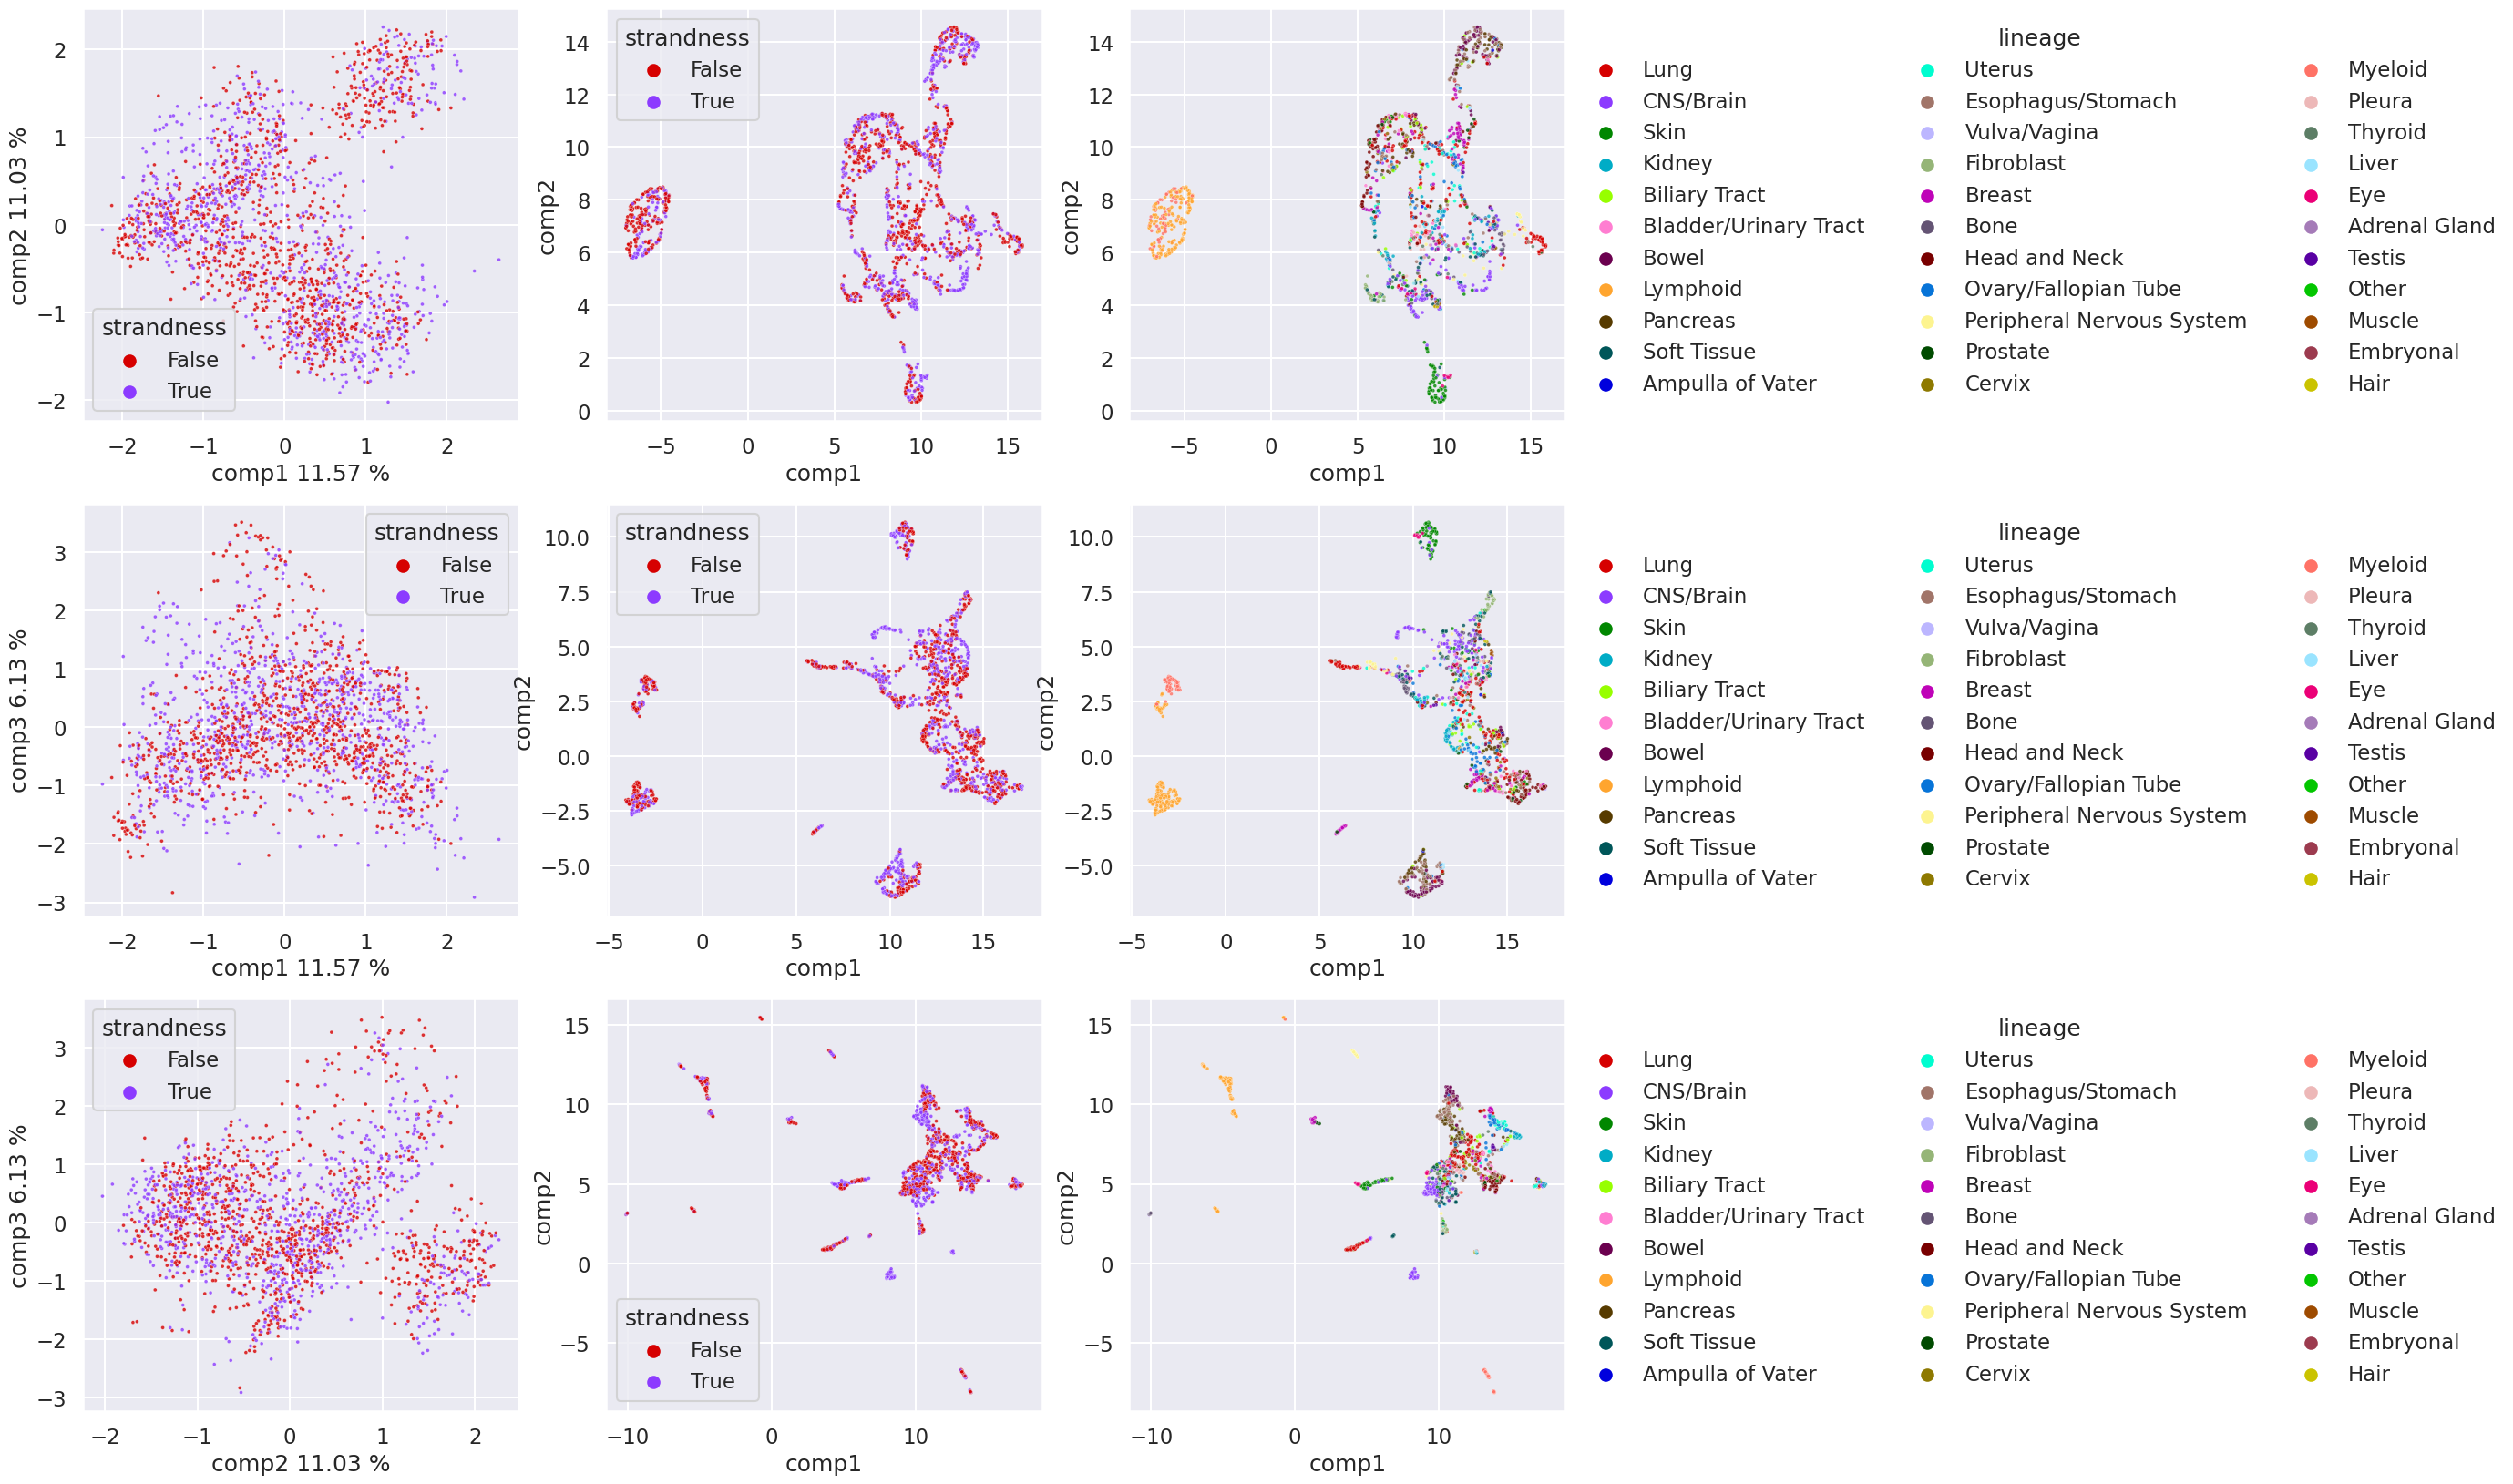

In [56]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(tpm_corrected.T)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)
